In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gc import collect as collect_garbage
from psutil import virtual_memory
from os import scandir

In [2]:
%matplotlib widget

In [3]:
folder = "../01-rpeaks/"

In [4]:
def lower_threshold(df, thresh=0.25):
    filt = df["interval"] >= thresh
    filt.loc[0] = True
    out = pd.DataFrame.copy(df.loc[filt], deep=True)
    out.reset_index(inplace=True, drop=True)
    out["interval"] = out["time"].diff()
    return out

def upper_threshold(df, thresh=5):
    filt = df["interval"] <= 5
    filt.loc[0] = True
    out = pd.DataFrame.copy(df.loc[filt], deep=True)
    out.reset_index(inplace=True, drop=True)
    return out

def clean_multiple_intervals(df):
    # Round the length of the next interval relative to the previous one
    N = len(df["interval"])
    pieces = np.round(df.loc[1:,"interval"]/df.loc[0:N-1, "interval"])
    return pieces

    # Make sure we don't introduce any intervals smaller than 0.25
    interval_lengths = df["interval"]



    return

In [5]:
# Clean up the RR intervals
for i in range(1,8):
    mod_counter = {
        "too small": 0,
        "too large": 0,
        "multiple intervals": 0
    }

    print("Starting now with infant "  +str(i))

    # Get the names of the rpeak files
    files = sorted( [file.name for file in scandir(folder) if str(i) in file.name] )
    
    # Concatenate all of these dataframes
    df = pd.read_csv( folder + files[0] )
    for file in files[1:]:
        df = df.append( pd.read_csv(folder + file) )
        collect_garbage()
    
    # Calculate the RR intervals
    df["interval"] = df["time"].diff()
    initial = len(df["interval"])

    # Apply lower and upper thresholds
    df = lower_threshold(df, thresh=0.25)
    collect_garbage()
    final = len(df["interval"])
    mod_counter["too small"] = initial-final
    initial = final

    df = upper_threshold(df, thresh=5)
    collect_garbage()
    final = len(df["interval"])
    mod_counter["too large"] = initial-final

    # Throw out the NaN at the beginning of the dataset
    df = df.loc[1:]

    # Output summary
    print("Infant "+str(i)+" Modification Summary")
    for key in mod_counter.keys():
        print(key + ": " + str(mod_counter[key]))
    print()

    if i == 2:
        break

Starting now with infant 1
Infant 1 Modification Summary
too small: 6019
too large: 335
multiple intervals: 0

Starting now with infant 2
Infant 2 Modification Summary
too small: 4437
too large: 83
multiple intervals: 0



In [6]:
# Break up multiple intervals
N = len(df["interval"])
pieces = np.round(df.loc[1:,"interval"].divide(df.loc[0:N-1,"interval"]))

In [7]:
pieces.value_counts()

1.0    3475477
Name: interval, dtype: int64

In [8]:
virtual_memory()

svmem(total=12655771648, available=6704357376, percent=47.0, used=5951414272, free=6704357376)

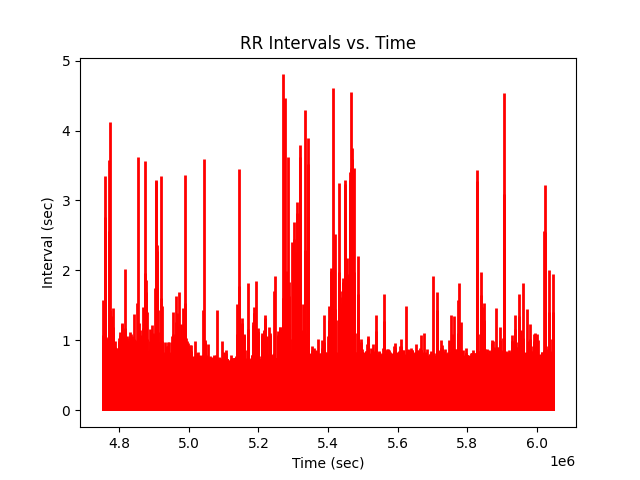

In [9]:
fig = plt.figure()
plt.vlines(df["time"], 0, df["interval"], color="red", linewidth=2)
plt.xlabel("Time (sec)")
plt.ylabel("Interval (sec)")
plt.title("RR Intervals vs. Time")
plt.show()

In [10]:
virtual_memory()

svmem(total=12655771648, available=583483392, percent=95.4, used=12072288256, free=583483392)

In [68]:
# Clean up the RR intervals
for i in range(1,8):
    print("Starting now with infant " + str(i))

    # Get the names of the rpeak files
    files = sorted( [file.name for file in scandir(folder) if str(i) in file.name] )
    
    # Concatenate all of these dataframes
    df = pd.read_csv( folder + files[0] )
    for file in files[1:]:
        df = df.append( pd.read_csv(folder + file) )
        collect_garbage()
    
    # Calculate the RR intervals
    df["interval"] = df["time"].diff()
    print("Starting DF")
    print(df.head())
    print()

    # Recalculate RR intervals while ignoring beats whose RR intervals are < 0.25 seconds
    filt = df["interval"] >= 0.25

    buffer = pd.DataFrame.copy(df.loc[filt], deep=True)
    buffer.reset_index(inplace=True, drop=True)
    buffer["interval"] = buffer["time"].diff()

    del df; collect_garbage()
    df = pd.DataFrame.copy(buffer, deep=True)
    del buffer; collect_garbage()
    print("Over .25")
    print(df.head())
    print()

    # Remove intervals of length greater than 5 seconds (arbitrary threshold)
    # The resulting gaps will just be treated as missing data
    filt = df["interval"] <= 5
    df = df.loc[filt]
    df.reset_index(inplace=True, drop=True)
    print("Under 5")
    print(df.head())
    print()

    # Throw out the NA at the beginning
    #df = df.loc[1:]

    # Remove any remaining multiple intervals
    
    

    break

Starting now with infant 1
Starting DF
            time  interval
0  345600.265306       NaN
1  345600.642058  0.376752
2  345601.010424  0.368366
3  345601.393469  0.383045
4  345601.779318  0.385849

Over .25
            time  interval
0  345600.642058       NaN
1  345601.010424  0.368366
2  345601.393469  0.383045
3  345601.779318  0.385849
4  345602.158719  0.379400



In [62]:
df

,time,interval
0,3.456010e+05,0.368366
1,3.456014e+05,0.383045
2,3.456018e+05,0.385849
3,3.456022e+05,0.379400
4,3.456025e+05,0.365029
...,...,...
3439468,1.641598e+06,0.376226
3439469,1.641599e+06,0.382623
3439470,1.641599e+06,0.368281
3439471,1.641599e+06,0.358440


In [38]:
# This cell tests if concatenating the dataframes works as expected
df.reset_index(drop=True,inplace=True)

print(df)

df1 = pd.read_csv(folder+files[0])
df2 = pd.read_csv(folder+files[1])
df3 = pd.read_csv(folder+files[2])
df4 = pd.read_csv(folder+files[3])
df5 = pd.read_csv(folder+files[4])

len(df1["time"]) + len(df2["time"]) + len(df3["time"]) + len(df4["time"]) + len(df5["time"])

In [51]:
# This cell tests if recalculating RR intervals while ignoring beats less than
# 0.25 seconds was a success. If so, the result should be 0
sum(df["interval"] < 0.25)

0

In [52]:
max([True, False])

True